# Pydra
## Registration Workflow with ANTsPy and FreeSurfer's SynthStrip

####

**Author**: Monika Doerig

**Date**: 2 Sep 2025

### Citation and Resources:


#### Tools included in this workflow
__Pydra__: 
- Jarecka, D., Goncalves, M., Markiewicz, C. J., Esteban, O., Lo, N., Kaczmarzyk, J., Cali, R., Herholz, P., Nielson, D. M., Mentch, J., Nijholt, B., Johnson, C. E., Wigger, J., Close, T. G., Vaillant, G., Agarwal, A., & Ghosh, S. (2025). nipype/pydra: 1.0a2 (1.0a2). Zenodo. [https://doi.org/10.5281/zenodo.16671149](https://doi.org/10.5281/zenodo.16671149)
- [<img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png" width="20"> nipype/pydra](https://github.com/nipype/pydra)

__ANTsPy__:

- stnava, Philip Cook, Nick Tustison, Ravnoor Singh Gill, John Muschelli, Jennings Zhang, Daniel Gomez, Andrew Berger, Thiago Franco de Moraes, Stephen Ogier, Asaph Zylbertal, Dean Rance, Pradeep Reddy Raamana, Vasco Diogo, sai8951, Bryn Lloyd, Dženan Zukić, Evert de Man, KYY, … Tommaso Di Noto. (2025). ANTsX/ANTsPy: Aiouea (v0.6.1). Zenodo. [https://doi.org/10.5281/zenodo.15742355](https://doi.org/10.5281/zenodo.15742355)
- Tustison, N.J., Cook, P.A., Holbrook, A.J. et al. The ANTsX ecosystem for quantitative biological and medical imaging. Sci Rep 11, 9068 (2021). https://doi.org/10.1038/s41598-021-87564-6
- [Documentation ANTsPy](https://antspy.readthedocs.io/en/latest/index.html#)
-  [<img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png" width="20"> ANTsX/ANTsPy](https://github.com/ANTsX/ANTsPy)





__SynthStrip:__

- SynthStrip: Skull-Stripping for Any Brain Image; Andrew Hoopes, Jocelyn S. Mora, Adrian V. Dalca, Bruce Fischl*, Malte Hoffmann* (*equal contribution); NeuroImage 260, 2022, 119474; [https://doi.org/10.1016/j.neuroimage.2022.119474](https://doi.org/10.1016/j.neuroimage.2022.119474)
- Boosting skull-stripping performance for pediatric brain images; William Kelley, Nathan Ngo, Adrian V. Dalca, Bruce Fischl, Lilla Zöllei*, Malte Hoffmann* (*equal contribution); IEEE International Symposium on Biomedical Imaging (ISBI), 2024, forthcoming; [https://arxiv.org/abs/2402.16634](https://arxiv.org/abs/2402.16634)
- [Documentation](https://w3id.org/synthstrip)


#### Dataset
__Opensource Data from OpenNeuro:__
- Kelly AMC and Uddin LQ and Biswal BB and Castellanos FX and Milham MP (2018). Flanker task (event-related). [OpenNeuro Dataset ds000102](https://openneuro.org/datasets/ds000102/versions/00001)
- Kelly, A.M., Uddin, L.Q., Biswal, B.B., Castellanos, F.X., Milham, M.P. (2008). Competition between functional brain networks mediates behavioral variability. Neuroimage, 39(1):527-37

## Installation and Import

In [1]:
%%capture
! pip install pydra==1.0a7 antspyx==0.6.1 nilearn nibabel #pydra==1.0a7, 1.0a4

In [2]:
from pathlib import Path
from pydra.compose import python, workflow, shell
from pydra.engine.submitter import Submitter
from pydra.utils import show_workflow, print_help
import pydra.utils.general
import shutil
from os.path import join as opj
import os 
import ants
import numpy as np
import nibabel as nib
from nilearn.datasets import load_mni152_template
from nilearn import plotting, image
from nilearn.image import math_img
import typing as ty
from fileformats.generic import File
import nest_asyncio

In [3]:
# Needed to allow asynchronous execution in Jupyter notebooks
nest_asyncio.apply()

In [4]:
import module
await module.load('freesurfer/8.1.0')
await module.list()

['freesurfer/8.1.0']

## Introduction Pydra
Pydra is a lightweight, Python-based dataflow engine designed to build reproducible, scalable, and robust workflows. While it was created to succeed Nipype for neuroimaging applications, Pydra is flexible enough to support analytic pipelines in any scientific domain. It allows you to combine tasks implemented as Python functions or shell commands into coherent workflows that can be executed reliably across different computing environments.

Key features include:

- Combining diverse tasks into robust workflows.

- Dynamic workflow construction using standard Python code.

- Concurrent execution on local workstations or HPC clusters (SLURM, SGE, Dask, etc.).

- Map-reduce-style parallelism via `split()` and `combine()`.

- Global caching to avoid unnecessary recomputation.

- Support for executing tasks in separate software environments (e.g., containers).

- Strong type-checking of inputs and outputs, including specialized file formats.

### Overview of the Preprocessing Workflow

In this notebook, we demonstrate a neuroimaging registration workflow built with Pydra. The workflow uses:

- Python tasks unsing `ANTsPy` for operations implemented directly in Python.
  
- Shell task to wrap FreeSurfer's command-line tool `SynthStrip` for skull-stripping.

- A workflow that orchestrates multiple tasks, connecting inputs and outputs.

- Splitting to process multiple functional runs in parallel.

- A Submitter object to  to initiate the task execution for a richer Result object

- Concurrent execution  using the `cf` (ConcurrentFutures) worker.

## 1. Download of Data

### One Subject from the Flanker Dataset from OpenNeuro

In [5]:
!datalad install https://github.com/OpenNeuroDatasets/ds000102.git
!cd ds000102 && datalad get sub-01 

Cloning:   0%|                             | 0.00/2.00 [00:00<?, ? candidates/s]
Enumerating: 0.00 Objects [00:00, ? Objects/s]
                                              
Counting:   0%|                               | 0.00/27.0 [00:00<?, ? Objects/s]
                                                                                
Compressing:   0%|                            | 0.00/23.0 [00:00<?, ? Objects/s]
                                                                                
Receiving:   0%|                             | 0.00/2.15k [00:00<?, ? Objects/s]
                                                                                
Resolving:   0%|                                | 0.00/537 [00:00<?, ? Deltas/s]
[INFO   ] Remote origin not usable by git-annex; setting annex-ignore           
[INFO   ] https://github.com/OpenNeuroDatasets/ds000102.git/config download failed: Not Found 
[INFO   ] access to 1 dataset sibling s3-PRIVATE not auto-enabled, enable with:
| 

### MNI template from Nilearn

In [6]:
mni_template = load_mni152_template(resolution=2)
nib.save(mni_template, './mni_template.nii.gz')

temp = Path('./mni_template.nii.gz')
template = temp.resolve()  # returns absolute path
print(template)

/home/jovyan/Git_repositories/neurodeskedu/books/examples/workflows/mni_template.nii.gz


## 2. Pydra Tasks
The basic runnable component of Pydra is a `task`. Tasks are conceptually similar to functions, in that they take inputs, operate on them and then return results. However, unlike standard functions, tasks are parameterized before execution in a separate step. This separation enables parameterized tasks to be linked together into workflows that can be validated for errors before execution, while allowing modular execution workers and environments to be specified independently of the task being performed.

Tasks can encapsulate **Python functions** or **shell-commands**, or be **multi-component workflows** themselves, constructed from task components including nested workflows.

### 2.1. Python Tasks
Python tasks are Python functions that are parameterized before they are executed or added to a workflow. This approach provides several advantages over direct function calls, including input validation, output tracking, and seamless integration into larger computational workflows.

#### Define decorator
The simplest way to define a Python task is to decorate a function with `pydra.compose.python.define`.

This neuroimaging registration pipeline demonstrates this approach by creating five specialized Python tasks with **ANTsPy** that handle different aspects of fMRI data processing:

1. **Motion correction task** - Corrects for head movement by registering all volumes to a reference timepoint
2. **Structural-to-MNI registration task** - Registers the T1-weighted anatomical image to MNI standard space
3. **Functional-to-structural registration task** - Registers the reference functional volume to the skull-stripped T1 image
4. **Transform combination task** - Concatenates the transformation matrices in the proper order for ANTs
5. **Transform application task** - Applies the combined transformations to register the motion-corrected functional data to MNI space

In [7]:
# Motion correction of BOLD images

@python.define
def motion_correction_ants(epi):
    
    cwd = os.getcwd()
    new_filename = Path(epi).name.replace('.nii.gz', '_mc.nii.gz') #new file ending for output file
    out_path = opj(cwd, new_filename)

    epi_path = str(epi) #make sure it's string
    epi_img = ants.image_read(epi_path)

    # Split into list of 3D volumes
    volumes = ants.ndimage_to_list(epi_img)
    
    # Pick reference volume (middle timepoint)
    ref_vol = volumes[len(volumes) // 2]
    
    # Motion correct each volume
    motion_corrected = []
    for i, vol in enumerate(volumes):
        reg = ants.registration(fixed=ref_vol, moving=vol, type_of_transform="Rigid") 
        motion_corrected.append(reg["warpedmovout"])
    
    # Recombine into 4D
    epi_corrected = ants.list_to_ndimage(epi_img, motion_corrected)
    ants.image_write(epi_corrected, out_path)

    return out_path

In [8]:
# Register BOLD to T1w

@python.define(outputs=["tx_EPI2T1", "warpedmovout"])
def reg_EPI2T1(bet_anat, func): 
    
    cwd = os.getcwd()
    bet_anat_path = str(bet_anat)

    # Load 4D fMRI
    img = nib.load(func)
    data = img.get_fdata()

    # Get the middle volume
    n_timepoints = data.shape[3]
    middle_timepoint = n_timepoints // 2
    middle_vol = data[:, :, :, middle_timepoint]
    
    # Save
    ref_img = nib.Nifti1Image(middle_vol, img.affine, img.header)
    ref_path = opj(cwd, "bold_ref.nii.gz")
    nib.save(ref_img, ref_path)

    tx_EPI2T1= ants.registration(fixed=ants.image_read(bet_anat_path), 
                                 moving=ants.image_read(ref_path), 
                                 random_seed = 0,
                                 type_of_transform = 'SyNBold', 
                                 outprefix= opj(os.getcwd(), 'EPI2T1_'))
    
    moved_path = opj(cwd ,'EPI2T1.nii.gz')
    ants.image_write(tx_EPI2T1['warpedmovout'], moved_path)
    
    return tx_EPI2T1['fwdtransforms'], moved_path

In [9]:
# Register T1w to MNI

@python.define(outputs=["tx_struct2MNI", "warpedmovout"])
def reg_struct2MNI(template, bet_anat):

    bet_anat_path = str(bet_anat)

    tx_struct2MNI= ants.registration(fixed=ants.image_read(template), 
                                   moving=ants.image_read(str(bet_anat_path)),
                                   random_seed = 0,
                                   type_of_transform = 'SyN', outprefix= opj(os.getcwd(), 'SyN_struct2MNI_'))

    moved_path = opj(os.getcwd() ,'T12MNI.nii.gz')
    ants.image_write(tx_struct2MNI['warpedmovout'], moved_path)
                                     
    return (tx_struct2MNI['fwdtransforms'], moved_path) 

In [10]:
# Concatenate transformations - last transformation is applied first

@python.define(outputs=["transform_list"])
def collect_transforms(tx_struct2mni, tx_epi2t1):
    return  tx_struct2mni + tx_epi2t1

In [11]:
# Apply transformations BOLD --> T1, T1 --> MNI; BOLD >> MNI in one step 

@python.define
def applyTransform_epi2mni(template, func, transform_list):

    cwd = os.getcwd()
    new_filename = Path(func).name.replace('_mc.nii.gz', '_mc_mni.nii.gz')
    out_path = opj(cwd, new_filename)

    func_path = str(func)

    mov_epi2mni = ants.apply_transforms(fixed = ants.image_read(template), 
                                        moving = ants.image_read(func_path),  
                                        transformlist=transform_list,
                                        interpolator='lanczosWindowedSinc', imagetype=3)

    file_path_gz = opj(cwd ,out_path)
    ants.image_write(mov_epi2mni, file_path_gz)
    
    return file_path_gz

### 2.2 Shell-tasks 

In **Pydra**, shell tasks can be defined using command-line style templates, which closely resemble the syntax shown in a tool’s inline help. This approach provides a concise and intuitive way to map a CLI program into a Python task that can be used in workflows.

Key features of the shell tasks:
- __Input and Outputs:__
  - Fields are enclosed in `< >`.
  - Outputs are marked with the `out|` prefix (e.g., `<out|out_file:File>`).
  - By default, fields are treated as `fileformats.generic.FsObject`, but more specific types (e.g. `NiftiGz`, `float`, `bool`) can be specified with `:<type>`

- __Flags and Options:__
  - Flags are associated with fields by placing the field after the flag (e.g., `-i <image:File>`).
  - Boolean flags are included only if the value is True, and omitted otherwise (e.g., `-g<gpu?:bool> "` --> optional, and the default is `False`)
  - Options that take a value have the field inserted after the flag (e.g., `--model <model:File>`)
    
- __Optional Arguments:__
  - Adding `?` after the type marks a field as optional (e.g., `<border:float?>`).
  - Optional fields are omitted from the command if not set, allowing the underlying tool to use its own defaults.
 
- __Defaults__
  - A default value can be provided after `=` (e.g., `<border:float?=1>`, which will override the CLI default if desired)
  - Defaults allow tasks to run without explicitly setting every argument.
 
- __Path Templates for Outputs:__
    - By default, output fields are assigned a `path_template` derived from the field name and extension (e.g., `out_file.gz`).
    - You can override this default filename using `$` followed by a filename (e.g., `<out|mask_file:File$brain_mask.nii.gz>`).
    - The auto-generated filename will be used unless the user provides an explicit path when initializing the task.

We will create `SynthStrip shell task`  by wrapping FreeSurfer's `mri_synthstrip` skull-stripping tool. Let's first look at the help page:

In [12]:
! mri_synthstrip --help

usage: mri_synthstrip [-h] -i FILE [-o FILE] [-m FILE] [-d FILE] [-g]
                      [-b BORDER] [-t THREADS] [--no-csf] [--model FILE]

Robust, universal skull-stripping for brain images of any type.

optional arguments:
  -h, --help            show this help message and exit
  -i FILE, --image FILE
                        input image to skullstrip
  -o FILE, --out FILE   save stripped image to file
  -m FILE, --mask FILE  save binary brain mask to file
  -d FILE, --sdt FILE   save distance transform to file
  -g, --gpu             use the GPU
  -b BORDER, --border BORDER
                        mask border threshold in mm, defaults to 1
  -t THREADS, --threads THREADS
                        PyTorch CPU threads, PyTorch default if unset
  --no-csf              exclude CSF from brain border
  --model FILE          alternative model weights

If you use SynthStrip in your analysis, please cite:
----------------------------------------------------
SynthStrip: Skull-Stripping for A


###
The `SynthStrip` tool for robust skull-stripping can be expressed as shell task in just a few lines using this syntax:

In [13]:
SynthStrip = shell.define(
    "mri_synthstrip "
    "-i <image:File> "
    "-o <out|out_file:File$brain_stripped.nii.gz> "
    "-m <out|mask_file:File$brain_mask.nii.gz> "
    "-g<gpu?:bool> "
    "--no-csf<no_csf?:bool> "
    "-b <border:float?> " # CLI uses its default (1 mm)
    "--model <model:file?>"
)

In [14]:
print_help(SynthStrip)

------------------------------------
Help for Shell task 'mri_synthstrip'
------------------------------------

Inputs:
- executable: str | Sequence[str]; default = 'mri_synthstrip'
    the first part of the command, can be a string, e.g. 'ls', or a list, e.g.
    ['ls', '-l', 'dirname']
- image: generic/file ('-i')
- out_file: Path | bool; default = True ('-o')
    The path specified for the output file, if True, the default 'path
    template' will be used.
- mask_file: Path | bool; default = True ('-m')
    The path specified for the output file, if True, the default 'path
    template' will be used.
- border: float | None; default = None ('-b')
- model: generic/file | None; default = None ('--model')
- append_args: list[str | generic/file]; default-factory = list()
    Additional free-form arguments to append to the end of the command.

Outputs:
- out_file: generic/file
- mask_file: generic/file
- return_code: int
    The process' exit code.
- stdout: str
    The standard output st

### 3.3. Workflow

![Nested Workflow](https://raw.githubusercontent.com/nipype/pydra-tutorial/refs/heads/master/figures/nested_workflow.png)

In Pydra, workflows represent directed acyclic graphs (DAGs) of tasks, where individual tasks are connected through their inputs and outputs to form complex computational pipelines. Like tasks, workflows are defined as dataclasses, but instead of performing computations themselves, they orchestrate the execution of multiple interconnected components. 

Workflows are defined using the `@workflow.define` decorator applied to a constructor function, which specifies how tasks should be connected and executed. Within the constructor function, individual tasks are added to the workflow using `workflow.add()`. This returns an outputs object, whose fields serve as placeholders for the task’s eventual results. These placeholders can then be used as inputs to downstream tasks, establishing the dependencies that determine the workflow’s execution order. The workflow itself returns its specified outputs as a tuple once all tasks have completed.

In our preprocessing pipeline, we'll demonstrate how to combine our Python tasks (motion correction, registration, and transformation) with our shell task (skull stripping) into a cohesive workflow that processes functional MRI data from raw acquisition to standardized space registration.

In [15]:
@workflow.define(outputs=["anat_brain", "bold_preproc"])
def PreprocWorkflow(anat: str, func: str, template: str) -> ty.Tuple[File, File]:

    # Brain extraction
    synth_strip_task = workflow.add(SynthStrip(
                                    image=anat))

    # Register T1w to MNI
    struct2MNI_task = workflow.add(reg_struct2MNI(template=template, 
                            bet_anat=synth_strip_task.out_file))


    # Motion Correction
    mc_task =  workflow.add(motion_correction_ants(epi = func))

    # Register ref EPI to T1w -->tx_EPI2T1
    epi2T1_task = workflow.add(reg_EPI2T1(bet_anat=synth_strip_task.out_file,
                               func=mc_task.out))

    # Merge transformations
    merge_transforms = workflow.add(collect_transforms(tx_struct2mni=struct2MNI_task.tx_struct2MNI, 
                                          tx_epi2t1=epi2T1_task.tx_EPI2T1))

    # Resample func to mni
    apply_transform = workflow.add(applyTransform_epi2mni(template=template,
                                         func = mc_task.out,
                                         transform_list = merge_transforms.transform_list))

    return synth_strip_task.out_file, apply_transform.out

In [16]:
print_help(PreprocWorkflow)

----------------------------------------
Help for Workflow task 'PreprocWorkflow'
----------------------------------------

Inputs:
- anat: str
- func: str
- template: str
- constructor: Callable[]; default = PreprocWorkflow()

Outputs:
- anat_brain: generic/file
- bold_preproc: generic/file



Pydra workflows support splitting inputs across multiple tasks using the `split()` method. This is particularly useful in neuroimaging pipelines, where the same preprocessing steps need to be applied to multiple subjects, sessions, or runs. For example, a workflow can be executed over every NIfTI file in a directory by splitting the workflow’s input over the set of files. If the outputs are not combined with `combine()`, the splits will automatically propagate to downstream nodes.



In [17]:
func_run_dir = Path('./ds000102/sub-01/func').resolve() 
anat_sub_01 = Path('./ds000102/sub-01/anat/sub-01_T1w.nii.gz').resolve() 

wf_preproc = PreprocWorkflow(anat= anat_sub_01,
                            template=template
                             ).split(func=(f for f in func_run_dir.iterdir() if f.name.endswith(".nii.gz"))) #only nifti files, ignore json files
                           
result_wf = wf_preproc()

In [18]:
result_wf

SplitOutputs(anat_brain=[File('/home/jovyan/.cache/pydra/1.0a7/run-cache/workflow-45b839052fb75c51da4342683a379938/brain_stripped.nii.gz'), File('/home/jovyan/.cache/pydra/1.0a7/run-cache/workflow-45b839052fb75c51da4342683a379938/brain_stripped.nii (1).gz')], bold_preproc=[File('/home/jovyan/.cache/pydra/1.0a7/run-cache/workflow-45b839052fb75c51da4342683a379938/sub-01_task-flanker_run-2_bold_mc_mni.nii.gz'), File('/home/jovyan/.cache/pydra/1.0a7/run-cache/workflow-45b839052fb75c51da4342683a379938/sub-01_task-flanker_run-1_bold_mc_mni.nii.gz')])

## 3. Submitter
If you want to access a richer `Result` object you can use a `Submitter` object to initiate the task execution. 

The Result object contains:

- output: the outputs of the task (if there is only one output it is called out by default)
- runtime: information about the peak memory and CPU usage
- errored: the error status of the task
- task: the task object that generated the results
- cache_dir: the output directory the results are stored in

In [19]:
shutil.rmtree(pydra.utils.general.default_run_cache_root) # Clear previous workflow results so we can showcase execution again
              
wf_sub = PreprocWorkflow(anat= anat_sub_01,
                            template=template
                             ).split(func=(f for f in func_run_dir.iterdir() if f.name.endswith(".nii.gz")))
with Submitter() as sub:
    result_sub = sub(wf_sub)

In [20]:
result_sub.task

Split(defn=PreprocWorkflow(anat='/home/jovyan/Git_repositories/neurodeskedu/books/examples/workflows/ds000102/.git/annex/objects/Pf/6k/MD5E-s10581116--757e697a01eeea5c97a7d6fbc7153373.nii.gz/MD5E-s10581116--757e697a01eeea5c97a7d6fbc7153373.nii.gz', func=StateArray('/home/jovyan/Git_repositories/neurodeskedu/books/examples/workflows/ds000102/sub-01/func/sub-01_task-flanker_run-2_bold.nii.gz', '/home/jovyan/Git_repositories/neurodeskedu/books/examples/workflows/ds000102/sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz'), template='/home/jovyan/Git_repositories/neurodeskedu/books/examples/workflows/mni_template.nii.gz', constructor=<function PreprocWorkflow at 0x7fd02e1cc5e0>), output_types={'anat_brain': out(name='anat_brain', type=list[fileformats.generic.file.File], default=NO_DEFAULT, help='', requires=[], converter=None, validator=None, hash_eq=False), 'bold_preproc': out(name='bold_preproc', type=list[fileformats.generic.file.File], default=NO_DEFAULT, help='', requires=[], convert

In [21]:
result_sub.cache_dir

PosixPath('/home/jovyan/.cache/pydra/1.0a7/run-cache/workflow-45b839052fb75c51da4342683a379938')

In [22]:
result_sub.outputs

SplitOutputs(anat_brain=[File('/home/jovyan/.cache/pydra/1.0a7/run-cache/workflow-45b839052fb75c51da4342683a379938/brain_stripped.nii.gz'), File('/home/jovyan/.cache/pydra/1.0a7/run-cache/workflow-45b839052fb75c51da4342683a379938/brain_stripped.nii (1).gz')], bold_preproc=[File('/home/jovyan/.cache/pydra/1.0a7/run-cache/workflow-45b839052fb75c51da4342683a379938/sub-01_task-flanker_run-2_bold_mc_mni.nii.gz'), File('/home/jovyan/.cache/pydra/1.0a7/run-cache/workflow-45b839052fb75c51da4342683a379938/sub-01_task-flanker_run-1_bold_mc_mni.nii.gz')])

## 4. Executing tasks in parallel

#### Workers

Pydra allows tasks to be executed in parallel using different workers. The default is the *debug* worker, which runs tasks serially in a single process; useful for debugging but not optimal for production.

For local parallel execution, the `cf` (ConcurrentFutures) worker can spread tasks across multiple CPU cores for better efficiency. On HPC clusters, SLURM, SGE, and PSI/J workers can submit workflow nodes as separate jobs to the scheduler. There is also an experimental Dask worker with multiple backend options.

Workers can be specified by string or by class, and additional parameters (e.g., `n_procs=2`) can be passed at execution.
When running multi-process code in a Python script, the workflow execution should be enclosed in an if __name__ == "__main__": block to prevent the worker processes from re-executing the top-level script.
This guard is not required when running inside a Jupyter Notebook.

In [23]:
shutil.rmtree(pydra.utils.general.default_run_cache_root) # Clear previous workflow results so we can showcase execution

# Use this block when calling multi-process code in a top level script
# if __name__ == "__main__":

# Use the 'cf' worker to run tasks concurrently
wf_parallel=PreprocWorkflow(anat= anat_sub_01,
                            template=template
                         ).split(func=(f for f in func_run_dir.iterdir() if f.name.endswith(".nii.gz")))

result_parallel = wf_parallel(worker="cf", n_procs=2) # <-- Select the "cf" worker here

In [24]:
result_parallel

SplitOutputs(anat_brain=[File('/home/jovyan/.cache/pydra/1.0a7/run-cache/workflow-45b839052fb75c51da4342683a379938/brain_stripped.nii.gz'), File('/home/jovyan/.cache/pydra/1.0a7/run-cache/workflow-45b839052fb75c51da4342683a379938/brain_stripped.nii (1).gz')], bold_preproc=[File('/home/jovyan/.cache/pydra/1.0a7/run-cache/workflow-45b839052fb75c51da4342683a379938/sub-01_task-flanker_run-2_bold_mc_mni.nii.gz'), File('/home/jovyan/.cache/pydra/1.0a7/run-cache/workflow-45b839052fb75c51da4342683a379938/sub-01_task-flanker_run-1_bold_mc_mni.nii.gz')])

## 5. Visualizing Results

### Workflow overview: tasks, inputs, and outputs
The figure below shows the full workflow execution graph, including all tasks, their inputs, and outputs. This provides a visual overview of the data flow and dependencies across the preprocessing steps.

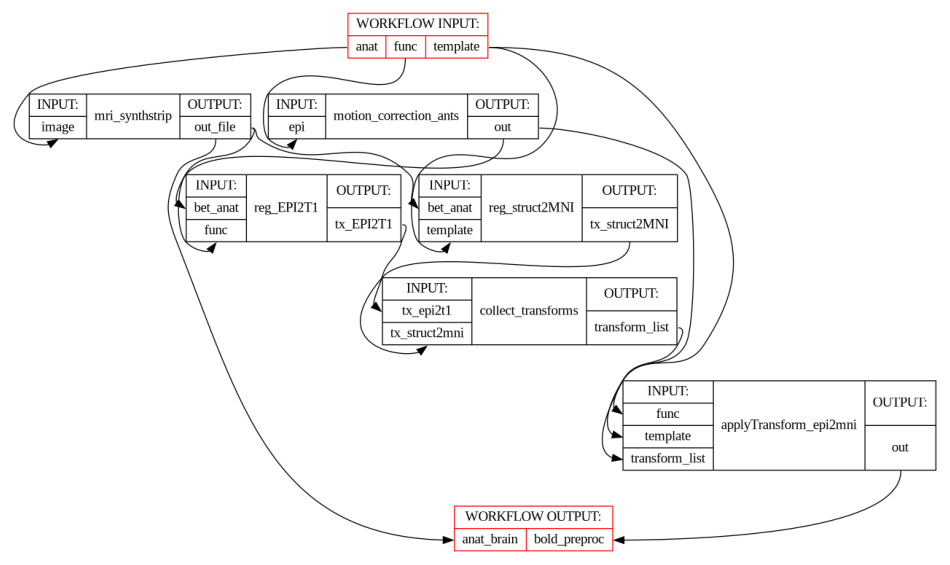

In [25]:
show_workflow(PreprocWorkflow, plot_type="detailed", figsize=(12, 8))

### Functional registration to MNI space
The mean BOLD image after motion correction was registered to the MNI template. The overlays below allows for visual inspection of alignment quality.

In [26]:
# Get mean BOLD image
mean_bold = image.mean_img(result_parallel.bold_preproc[0], copy_header=True)

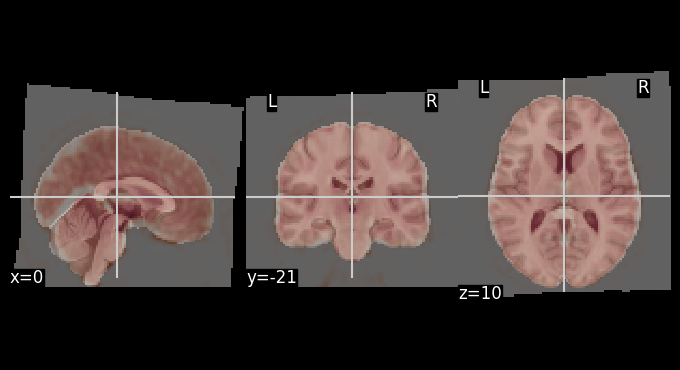

In [27]:
# Overlay of the mean bold image on MNI background template
plotting.plot_stat_map(stat_map_img=mean_bold, 
                  bg_img=template,
                  transparency=0.4, 
                  colorbar=False) 

Let's use `add_contours` as another visualization option for checking coregistration by overlaying the MNI template as contour (red) on top of mean functional image (background):

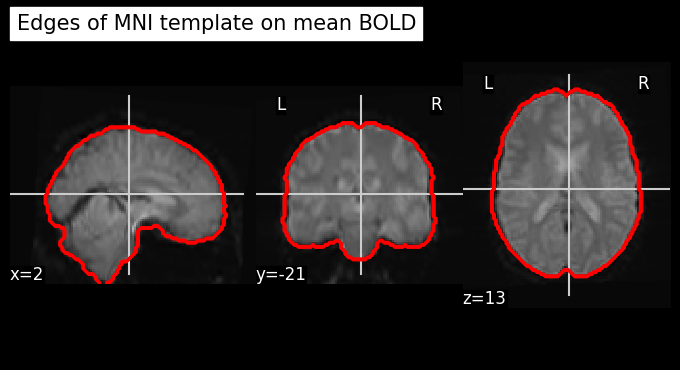

In [28]:
# Create a binary mask of the template
template_mask = math_img("img > 0.1", img=template)

display = plotting.plot_anat(mean_bold, title="Edges of MNI template on mean BOLD", colorbar=False)
display.add_contours(template_mask, colors='r')


#### Dependencies in Jupyter/Python
- Using the package [watermark](https://github.com/rasbt/watermark) to document system environment and software versions used in this notebook

In [29]:
%load_ext watermark

%watermark
%watermark --iversions

Last updated: 2026-02-13T12:57:15.152084+00:00

Python implementation: CPython
Python version       : 3.13.9
IPython version      : 9.7.0

Compiler    : GCC 14.3.0
OS          : Linux
Release     : 5.15.0-164-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

ants        : 0.6.1
fileformats : 0.17.0
nest_asyncio: 1.6.0
nibabel     : 5.3.3
nilearn     : 0.13.1
numpy       : 2.3.5
pydra       : 1.0a7

